In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam, SGD
import json
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# read data from csv file

# more or less log outputs
debug = True 
test_data = False

if (test_data):
    csv_file = 'driving_log_test.csv'
else: 
    csv_file = 'driving_log.csv'

###
# Reads data from the csv file with the collected data
# Returns two arrays: images and angle (steering angle info)
###
def read_data_from_csv_file(csv_file):
    images, steering = [], []
    with open(csv_file) as csvfile:
        reader = csv.DictReader(csvfile)
        degrees = 30
        correction = degrees *0.01
        for row in reader:
            steering_value = float(row['steering'])
            if (steering_value > 0.30 or steering_value < -0.30):
                images.append(row['center'])
                steering.append(steering_value)
                # adding left camera images
                images.append(row['left'].strip())
                steering.append(steering_value + correction)
                # adding right camera images
                images.append(row['right'].strip())
                steering.append(steering_value - correction)
    return images, steering
    

    
images_raw, steering_raw = read_data_from_csv_file(csv_file)
if (debug):
    print("\nLoaded",len(images_raw),"images -",len(steering_raw),"steering angles from csv file",csv_file)


Loaded 744 images - 744 steering angles from csv file driving_log.csv


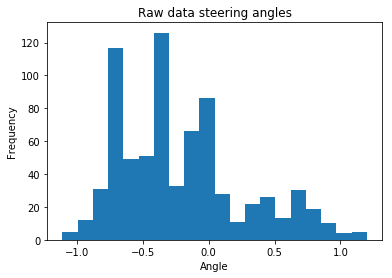

In [3]:
# distribution of loaded data
plt.hist(steering_raw, bins=20)
plt.title("Raw data steering angles")
plt.xlabel("Angle")
plt.ylabel("Frequency")
plt.show()

In [4]:
###
# Converts the images and steering data into
# training data and labels np arrays
###
def process_data(images, steering):
    show_images = False
    x,y = [],[]
    # process image
    current_images = len(images)
    if (debug):
        print("Recorded images", current_images)
    for i in range(current_images):
        # take a peek at the images printing out some stats and plotting
        image = mpimg.imread(images[i])
        if (show_images):
            print('Image',images[i],'dimensions:', image.shape,"steering",steering[i])
        #    plt.imshow(image)
        #    plt.show()
        img = cv2.imread(images[i]) # reads BGR format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # back to RGB format
        # adjust brightness with random intensity to simulate driving in different lighting conditions 
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        random_bright = .25+np.random.uniform()
        #print(random_bright)
        img[:,:,2] = img[:,:,2]*random_bright
        img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
        # crop image to get rid of unwanted pixels, like trees, car bonnet, etc
        crop_img = img[40:130]
        #if (show_images):
        #    print('Cropped image dimensions:', crop_img.shape,'Steering:',steering[i])
        #    plt.imshow(crop_img)
        #    plt.show()
        # resize image by half
        height, width = crop_img.shape[:2]
        new_width = int(width/2)
        new_height = int(height/2)
        resized_image = cv2.resize(crop_img,(new_width, new_height),fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
        if (show_images):
            print('Resized image dimesions:', resized_image.shape)
            plt.imshow(resized_image)
            plt.show()
        # crop image to remove non-road information
        #crop_img = resized_image[30:80, 0:160] # Crop from startY, endY, startX, endX
        
        #images[i] = resized_image
        flip_prob = np.random.random()
        if flip_prob > 0.5:
            # flip the image and reverse the steering angle
            flipped_image = cv2.flip(resized_image, 1)
            flipped_steering = steering[i]*(-1)
            images[i] = flipped_image
            steering[i] = flipped_steering
            if (show_images):
                print('Flipped image dimensions:', flipped_image.shape,'Steering:',flipped_steering)
                plt.imshow(flipped_image)
                plt.show()
        else :
            images[i] = resized_image
        if i > 40:
            show_images = False
    if (debug):
        print("Training images", len(images))
    x = np.array(images)
    #x = np.vstack(images)
    y = np.vstack(steering)
    return x,y

# do the tranformations: resize, trim, normalize
images_processed,steering_processed = process_data(images_raw, steering_raw)
if (debug):
    print("\nProcessed data: resized and trimmed")
    print("images_processed length",len(images_processed),"shape",images_processed.shape)
    print("steering_processed length",len(steering_processed),"shape",steering_processed.shape)

Recorded images 744
Training images 744

Processed data: resized and trimmed
images_processed length 744 shape (744, 45, 160, 3)
steering_processed length 744 shape (744, 1)


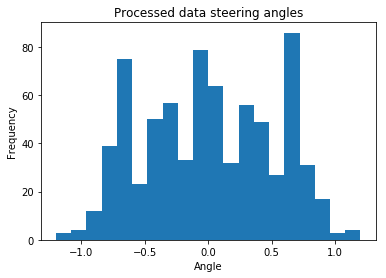

In [5]:
# distribution of processed data
plt.hist(steering_processed, bins=20)
plt.title("Processed data steering angles")
plt.xlabel("Angle")
plt.ylabel("Frequency")
plt.show()

In [6]:
# turn into np array
x = np.array(images_processed) 
y = np.vstack(steering_processed)

if (debug):
    print("\nData to array")
    print("x length",len(x),"shape",x.shape)
    print("y length",len(y),"shape",y.shape)


Data to array
x length 744 shape (744, 45, 160, 3)
y length 744 shape (744, 1)


In [7]:
###
# Splits data into training and test sets
###
def split_data(x,y):
    # Split into train and test data (20%)
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20, random_state=3234)
    return x_train, x_val, y_train, y_val

# split data into training and data sets    
train_features, val_features, train_labels, val_labels = split_data(x, y)
if (debug):
    print("\nSplit the data into training/testing:")
    print("- Training images length", len(train_features),"shape",train_features.shape)
    print("- Training labels length", len(train_labels),"shape",train_labels.shape)
    print("- Validation images length", len(val_features),"shape",val_features.shape)
    print("- Validation labels length", len(val_labels),"shape",val_labels.shape)


Split the data into training/testing:
- Training images length 595 shape (595, 45, 160, 3)
- Training labels length 595 shape (595, 1)
- Validation images length 149 shape (149, 45, 160, 3)
- Validation labels length 149 shape (149, 1)


In [8]:
# Shuffle the data
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

train_features, train_labels = unison_shuffled_copies(train_features, train_labels)
val_features, val_labels = unison_shuffled_copies(val_features, val_labels)
print("Shuffled the data")

Shuffled the data


In [9]:
# define model arquitecture
# modified version of https://raw.githubusercontent.com/commaai/research/master/train_steering_model.py
def get_model(time_len=1):
    channels, height, width = 3, 45, 160  # image format
    
    model = Sequential()
    model.add(Lambda(lambda x: x/255. - 0.5,
            input_shape=(height, width, channels),
            output_shape=(height, width, channels)))

    #model.add(Convolution2D(32, 3, 3, input_shape=(height, width, channels)))
    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
              
    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
              
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # the model so far outputs 3D feature maps (height, width, features)
    model.add(Flatten()) # converts 3D feature maps into 1D vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
              
    model.compile(optimizer="adam", loss="mse", metrics=['mse'])

    return model

if(debug):
    print("Model setup")

Model setup


In [ ]:
# write generator to feed data into the model
def feed_data_generator (image_train, labels_train, batch_size):
    total = (len(y) // batch_size ) * batch_size
    # number of images in the training set
    num_images = len(image_train)
    # create a random index
    random_index = np.random.choice(num_images, size=batch_size, replace=False)
    while True:
        # select the random images and labels with this random index
        features_batch = image_train[random_index,:]
        labels_batch = labels_train[random_index]  
        yield features_batch, labels_batch

if(debug):
    print("Feed data generator setup")

## Generator test
my_generator = feed_data_generator(train_features, train_labels, 20)
test_batch_images, test_batch_labels = next(my_generator)
print("test_batch_images shape",test_batch_images.shape)
print("test_batch_labels shape",test_batch_labels.shape)

Feed data generator setup
test_batch_images shape (20, 45, 160, 3)
test_batch_labels shape (20, 1)


In [ ]:
# train the model

epochs = 5
if (test_data):
    batch_size = 20
    samples_per_epoch = batch_size
    nb_val_samples = batch_size
else:
    batch_size = 128
    samples_per_epoch = ((len(train_labels) // batch_size ) * batch_size)*2
    nb_val_samples = ((len(val_labels) // batch_size ) * batch_size)*2
    
print("Samples per epoch",samples_per_epoch)
print("Validation samples per epoch",nb_val_samples)

def train_model(epochs, batch_size, samples_per_epoch, nb_val_samples):
    #model.summary()
    checkpoint = ModelCheckpoint(filepath="./model.h5", verbose=1, save_best_only=True)
    callbacks_list = [checkpoint]
    history = model.fit_generator(
        feed_data_generator(train_features, train_labels, batch_size),
        samples_per_epoch=samples_per_epoch,
        nb_epoch=epochs,
        verbose=1,
        callbacks = callbacks_list,
        validation_data = feed_data_generator(val_features, val_labels, batch_size),
        nb_val_samples = nb_val_samples) 
    return history
    
    
def show_graph(history):
    #print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def evaluate_model():
    metrics = model.evaluate(val_features, val_labels, batch_size=32, verbose=1)
    keys = model.metrics_names
    #print(keys)
    print(keys[0],":",metrics[0])
    print(keys[1],":",metrics[1])

model = get_model()
history = train_model(epochs, batch_size, samples_per_epoch, nb_val_samples)
#show_graph(history)

evaluate_model()

Samples per epoch 1024
Validation samples per epoch 256


C:\Users\Abhishek Jadav\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
C:\Users\Abhishek Jadav\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
C:\Users\Abhishek Jadav\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\Abhishek Jadav\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:27: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
C:\Users\Abhishek Jadav\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:27: UserWarning: Update your `

Epoch 1/5
 326/1024 [========>.....................] - ETA: 730s - loss: 0.0327 - mean_squared_error: 0.0327 

In [ ]:
# save arquitecture as model.json
with open('./model.json', 'w') as outfile:
        json.dump(model.to_json(), outfile)

print("Data saved")